# Dynamic Pricing for Urban Parking Lots

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:


df = pd.read_csv("dataset.csv")
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format="%d-%m-%Y %H:%M:%S")
df = df.sort_values(by=['SystemCodeNumber', 'timestamp']).reset_index(drop=True)


In [11]:
BasePrice = 10.0
alpha = 2.0 

df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce')
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce')



In [12]:
traffic_map = {"low": 0.0, "average": 0.5, "high": 1.0}
df['TrafficScore'] = df['TrafficConditionNearby'].map(traffic_map)
vehicle_weights = {"bike": 0.5, "car": 1.0, "truck": 2.0}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)


# Model 1: Baseline Linear Model
df['Price_Model1'] = np.nan
for code, group in df.groupby('SystemCodeNumber'):
    group = group.sort_values('timestamp')
    prices = [BasePrice]
    for i in range(1, len(group)):
        prev_price = prices[-1]
        row = group.iloc[i - 1]
        occ_ratio = row['Occupancy'] / row['Capacity'] if row['Capacity'] > 0 else 0
        new_price = prev_price + alpha * occ_ratio
        prices.append(min(new_price, 30))
    df.loc[group.index, 'Price_Model1'] = prices




In [13]:
weights = {
    'Occupancy': 0.4,
    'QueueLength': 0.2,
    'TrafficScore': 0.2,
    'SpecialDay': 0.1,
    'VehicleWeight': 0.1
}
lambda_factor = 0.5



# Model 2: Demand-Based Pricing
df['Price_Model2'] = np.nan
for code, group in df.groupby('SystemCodeNumber'):
    group = group.sort_values('timestamp')
    prices = []
    for i in range(len(group)):
        row = group.iloc[i]
        occ_ratio = row['Occupancy'] / row['Capacity'] if row['Capacity'] > 0 else 0
        demand = (
            weights['Occupancy'] * occ_ratio +
            weights['QueueLength'] * row['QueueLength'] +
            weights['TrafficScore'] * row['TrafficScore'] +
            weights['SpecialDay'] * row['IsSpecialDay'] +
            weights['VehicleWeight'] * row['VehicleWeight']
        )
        price = BasePrice * (1 + lambda_factor * demand)
        price = max(min(price, 20), 5)
        prices.append(price)
    df.loc[group.index, 'Price_Model2'] = prices



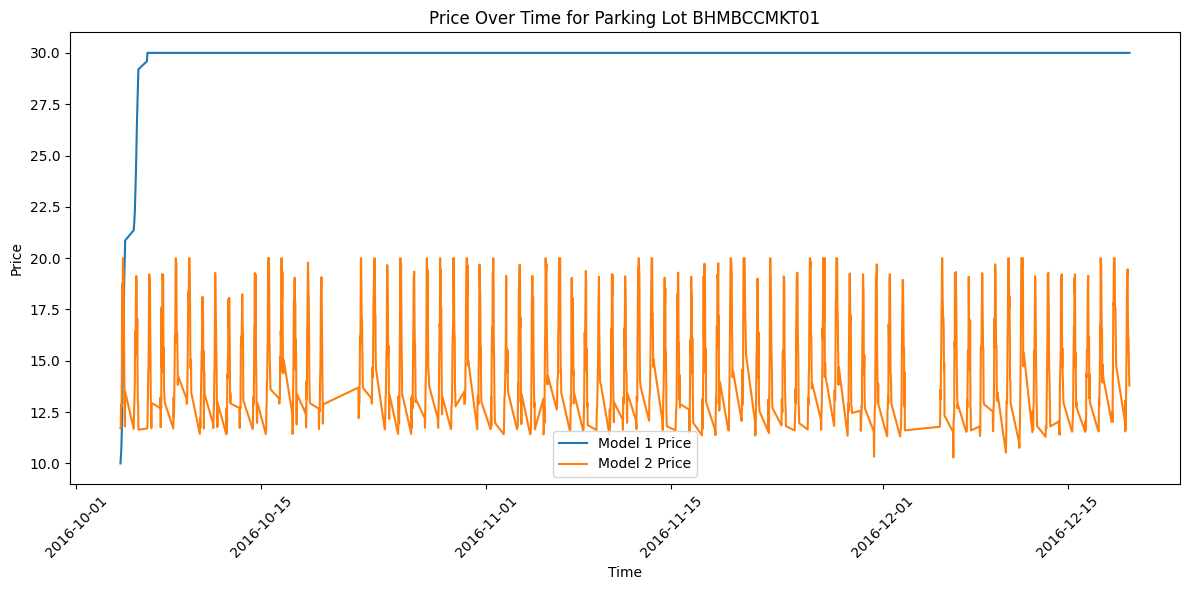

In [14]:
df.to_csv("Dynamic_Parking_Pricing_Models.csv", index=False)

lot_id = df['SystemCodeNumber'].unique()[0]
df_lot = df[df['SystemCodeNumber'] == lot_id]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_lot, x='timestamp', y='Price_Model1', label='Model 1 Price')
sns.lineplot(data=df_lot, x='timestamp', y='Price_Model2', label='Model 2 Price')
plt.title(f'Price Over Time for Parking Lot {lot_id}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

lot_id = df['SystemCodeNumber'].unique()[0]
df_lot = df[df['SystemCodeNumber'] == lot_id]

source = ColumnDataSource(df_lot)

p = figure(x_axis_type='datetime', title=f'Real-Time Pricing for Lot {lot_id}', height=400, width=800)
p.line('timestamp', 'Price_Model1', source=source, color='blue', legend_label='Model 1 Price', line_width=2)
p.line('timestamp', 'Price_Model2', source=source, color='green', legend_label='Model 2 Price', line_width=2)

hover = HoverTool(
    tooltips=[
        ('Time', '@timestamp{%F %T}'),
        ('Price Model 1', '@Price_Model1{0.00}'),
        ('Price Model 2', '@Price_Model2{0.00}')
    ],
    formatters={'@timestamp': 'datetime'}
)
p.add_tools(hover)

p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Price ($)'
p.legend.location = 'top_left'
p.grid.visible = True

show(p)

Loading BokehJS ...